In this notebook, the xgboost model trained in the feature_engineering_train notebook will be used to predict the probability of Tesla stock price hit the short strikes opened on each Monday. If this probability passes a certain threshold, an exit strategy will be executed. This algorithm is backtested agaist the last 6 month tesla data and mean return and volitility are presented.


In [242]:
import yfinance as yf
import pandas as pd    
import numpy as np
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import pickle
import requests
from xgboost import XGBClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [242]:
start_date = datetime.fromisoformat("2021-10-01")
end_date = datetime.fromisoformat("2022-04-09") 

prob_threshold = 0.16  # threshold prob. for closing the short positions corresponding to the prob of a portfolio with Sharpe=1 making loss

call_lim = [1.2, 1.25]   # initial value for price to short strike distance
put_lim = [.8, .75]

earning_dates = ['2021-10-20', '2022-01-26']

market_cal = pd.read_pickle('market_calendar')
data_tsla = pd.read_pickle('data_tesla_backtest_6month')
model = XGBClassifier()
model.load_model("model_xgboost_173estimators_depth4.json")

In [75]:
dates = data_tsla['Date']
data_tsla.drop(columns=['Date', 'close'], inplace=True)

# calculating the probability of each class (next day tsla price falling into 7 bins [.5 .85 .9 .95 1.05 1.1 1.15 1.5])
prob_alldays = model.predict_proba(data_tsla)
prob_alldays = dict(zip(dates, prob_alldays))

In [ ]:
df_main = yf.download('tsla', start=start_date, end=end_date, progress=False)

def allmondays(start_date, end_date):
    mondays = pd.date_range(start=str(start_date.year), end=str(end_date.year+1), freq='W-MON') 
    mondays = mondays[np.logical_and(mondays>=start_date, mondays<=end_date)]
    return mondays
mondays = allmondays(start_date, end_date)
st_dates = []        
for mon in mondays:
    if mon in market_cal:
        st_dates.append(mon) 
    else:
        st_dates.append(market_cal[market_cal>mon][0])
st_dates = np.array(st_dates)
df_main = df_main[df_main.index>=st_dates[0]]

def allfridays(start_date, end_date):    
    fridays = pd.date_range(start=str(start_date.year), end=str(end_date.year+1), freq='W-FRI')    
    fridays = fridays[np.logical_and(fridays>=start_date, fridays<=end_date)]
    return fridays
fridays = allfridays(start_date, end_date)
exp_date = []           
for frid in fridays:
    if frid in market_cal:
        exp_date.append(frid) 
    else:
        exp_date.append(market_cal[market_cal<frid][-1])   
exp_date = np.array(exp_date)

df_main['exp_date'] = df_main.index.map(lambda x: exp_date[x<=exp_date][0])
earning_week = [st_dates[st_dates<= datetime.fromisoformat(day)].max() for day in earning_dates]

In [245]:
def prob_loss(close, naked_price, prob, option_type):
    prob_cum_p = np.cumsum(prob[:-1])
    prob_cum_c = np.cumsum(prob[-1:0:-1])
    bins = np.array([.85, .9, .95, 1.05, 1.1, 1.15])
    if option_type== 'p':
        if naked_price <= .85*close:
            lossp = prob[0]*(naked_price/close-.5)/.35  
        else:
            lossp = np.interp(naked_price/close, bins, prob_cum_p)
    if option_type== 'c':
        if naked_price >= 1.15*close:
            lossp = prob[-1]*(1.5-naked_price/close)/.35 
        else:
            lossp = np.interp(naked_price/close, bins, prob_cum_c[-1::-1])            
    return lossp

def round_base(x, base):
    return int(base * round(x/base))

# calculating loss porbablity for short call/put in each day
df_main = df_main.join(pd.DataFrame(np.zeros((len(df_main), 4)), columns=['call_short', 'call_long', 'put_short', 'put_long'], dtype='int32').set_index(df_main.index))
for i, ind in enumerate(df_main.index):
    day = st_dates[st_dates<=ind].max()
    stock_price = df_main.loc[day, 'Close']
    if day in earning_week:    # for earning week, price-strike distance is increased by 5%
        df_main.loc[ind, 'call_short'] = round_base(stock_price*(call_lim[0]+.05), 10)
        df_main.loc[ind, 'call_long'] = round_base(stock_price*(call_lim[1]+.05), 10)                   
        df_main.loc[ind, 'put_short'] = round_base(stock_price*(put_lim[0]-.05), 10)
        df_main.loc[ind, 'put_long'] = round_base(stock_price*(put_lim[1]-.05), 10)
    else:       
        df_main.loc[ind, 'call_short'] = round_base(stock_price*call_lim[0], 10)
        df_main.loc[ind, 'call_long'] = round_base(stock_price*call_lim[1], 10)                   
        df_main.loc[ind, 'put_short'] = round_base(stock_price*put_lim[0], 10)
        df_main.loc[ind, 'put_long'] = round_base(stock_price*put_lim[1], 10)
                
    if ind == df_main.loc[ind,'exp_date']:
        df_main.loc[ind, ['prob_loss_cs', 'prob_loss_ps']] = 0
    else:
        df_main.loc[ind, 'prob_loss_cs'] = prob_loss(df_main.loc[ind, 'Close'], df_main.loc[ind, 'call_short'], prob_alldays[ind], 'c')
        df_main.loc[ind, 'prob_loss_ps'] = prob_loss(df_main.loc[ind, 'Close'], df_main.loc[ind, 'put_short'], prob_alldays[ind], 'p')

In [ ]:
# calculating the collected net premium on the start of each week

class PolygonPy:
    
    def __init__(self, token=None):
        self.token = token
        self.url = 'https://api.polygon.io/v1/open-close/O:' \
                   '{ticker}/{quote_date}?adjusted=true&apiKey={key}'
                   
    def set_token(self, token):
        self.token = token
                
    def get_options_data(self, ticker, type_, strike, exp_date, quote_date):        
        ticker_complete = ticker+exp_date+type_+f'{strike:05}'+'000'            
        url_formatted = self.url.format(ticker=ticker_complete, quote_date=quote_date, key=self.token)
        resp = requests.get(url_formatted)       
        return resp.status_code, resp.json()

polygonpy = PolygonPy()
polygonpy.set_token(myKey)
for day in st_dates[:]:
    if df_main.loc[day, 'prob_loss_cs']<=prob_threshold:
        status, data =  polygonpy.get_options_data('TSLA', 'C', df_main.loc[day,'call_short'], df_main.loc[day,'exp_date'].strftime("%y%m%d"), day.strftime("%Y-%m-%d"))  
        if status == 200:
            df_main.loc[day, 'return_cs'] = data['close']
        else:            
            new_call = round_base(df_main.loc[day, 'Close']*call_lim[0], 50)
            status, data =  polygonpy.get_options_data('TSLA', 'C', new_call, df_main.loc[day,'exp_date'].strftime("%y%m%d"), day.strftime("%Y-%m-%d"))  
            df_main.loc[day, 'return_cs'] = data['close']
            inds = market_cal[(day<=market_cal) & (market_cal<=df_main.loc[day,'exp_date'])] 
            df_main.loc[inds, 'call_short'] = new_call
            for ind in inds[:-1]:
                df_main.loc[ind, 'prob_loss_cs'] = prob_loss(df_main.loc[ind, 'Close'], new_call, prob_alldays[ind], 'c')
          
    if df_main.loc[day, 'prob_loss_cs']<=prob_threshold:
        status, data =  polygonpy.get_options_data('TSLA', 'C', df_main.loc[day,'call_long'], df_main.loc[day,'exp_date'].strftime("%y%m%d"), day.strftime("%Y-%m-%d"))    
        if status == 200:
            df_main.loc[day, 'return_cs'] -= data['close']
        else:            
            new_call = round_base(df_main.loc[day, 'Close']*call_lim[1], 50)
            status, data =  polygonpy.get_options_data('TSLA', 'C', new_call, df_main.loc[day,'exp_date'].strftime("%y%m%d"), day.strftime("%Y-%m-%d"))    
            df_main.loc[day, 'return_cs'] -= data['close']
            inds = market_cal[(day<=market_cal) & (market_cal<=df_main.loc[day,'exp_date'])] 
            df_main.loc[inds, 'call_long'] = new_call
           
    if df_main.loc[day, 'prob_loss_ps']<=prob_threshold:
        status, data =  polygonpy.get_options_data('TSLA', 'P', df_main.loc[day,'put_short'], df_main.loc[day,'exp_date'].strftime("%y%m%d"), day.strftime("%Y-%m-%d"))    
        if status == 200:
            df_main.loc[day, 'return_ps'] = data['close']
        else:     
            new_put = round_base(df_main.loc[day, 'Close']*put_lim[0], 50)
            status, data =  polygonpy.get_options_data('TSLA', 'P', new_put, df_main.loc[day,'exp_date'].strftime("%y%m%d"), day.strftime("%Y-%m-%d"))    
            df_main.loc[day, 'return_ps'] = data['close']
            inds = market_cal[(day<=market_cal) & (market_cal<=df_main.loc[day,'exp_date'])] 
            df_main.loc[inds, 'put_short'] = new_put
            for ind in inds[:-1]:
                df_main.loc[ind, 'prob_loss_ps'] = prob_loss(df_main.loc[ind, 'Close'], new_put, prob_alldays[ind], 'p')
          
    if df_main.loc[day, 'prob_loss_ps']<=prob_threshold:
        status, data =  polygonpy.get_options_data('TSLA', 'P', df_main.loc[day,'put_long'], df_main.loc[day,'exp_date'].strftime("%y%m%d"), day.strftime("%Y-%m-%d"))    
        if status == 200:
            df_main.loc[day, 'return_ps'] -= data['close']
        else:
            new_put = round_base(df_main.loc[day, 'Close']*put_lim[1], 50)
            status, data =  polygonpy.get_options_data('TSLA', 'P', new_put, df_main.loc[day,'exp_date'].strftime("%y%m%d"), day.strftime("%Y-%m-%d"))    
            df_main.loc[day, 'return_ps'] -= data['close']
            inds = market_cal[(day<=market_cal) & (market_cal<=df_main.loc[day,'exp_date'])] 
            df_main.loc[inds, 'put_long'] = new_put

In [266]:
#  exiting one side of iron condor when the prob. of loss passes the specified level

hairy_days_c = df_main.query('prob_loss_cs>@prob_threshold').index
for day in hairy_days_c:
    _, data_cs =  polygonpy.get_options_data('TSLA', 'C', df_main.loc[day,'call_short'], df_main.loc[day,'exp_date'].strftime("%y%m%d"), day.strftime("%Y-%m-%d"))    
    _, data_cl =  polygonpy.get_options_data('TSLA', 'C', df_main.loc[day,'call_long'], df_main.loc[day,'exp_date'].strftime("%y%m%d"), day.strftime("%Y-%m-%d"))    
    loss = - data_cs['close'] + data_cl['close']
    df_main.loc[st_dates[st_dates<=day].max(), 'return_cs'] += loss

hairy_days_p = df_main.query('prob_loss_ps>@prob_threshold').index
for day in hairy_days_p:        
    _, data_ps =  polygonpy.get_options_data('TSLA', 'P', df_main.loc[day,'put_short'], df_main.loc[day,'exp_date'].strftime("%y%m%d"), day.strftime("%Y-%m-%d"))    
    _, data_pl =  polygonpy.get_options_data('TSLA', 'P', df_main.loc[day,'put_long'], df_main.loc[day,'exp_date'].strftime("%y%m%d"), day.strftime("%Y-%m-%d"))    
    loss = - data_ps['close'] + data_pl['close']
    df_main.loc[st_dates[st_dates<=day].max(), 'return_ps'] += loss 

df_main['return'] = 100*(df_main['return_cs']+df_main['return_ps'])/(df_main['call_long']-df_main['call_short']+ df_main['put_short']-df_main['put_long'])

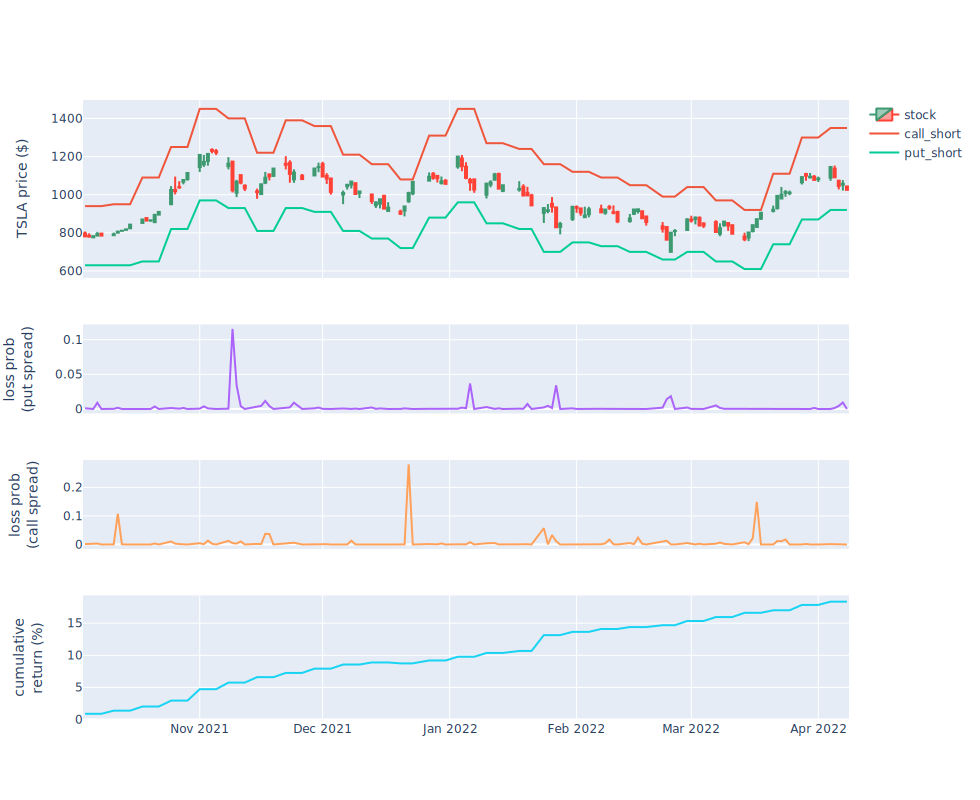

In [299]:
fig = make_subplots(rows=4, cols=1, row_heights=[10, 5, 5,7], shared_xaxes=True)
fig.add_trace(go.Candlestick(x=df_main.index, open=df_main['Open'], high=df_main['High'], low=df_main['Low'], close=df_main['Close'], name='stock'), row=1, col=1)
fig.update_layout(xaxis_rangeslider_visible=False)
fig.add_trace(go.Scatter(x=df_main.index, y=df_main.call_short, name='call_short'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_main.index, y=df_main.put_short, name='put_short'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_main.index, y=df_main.prob_loss_ps, showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=df_main.index, y=df_main.prob_loss_cs, showlegend=False), row=3, col=1)
fig.add_trace(go.Scatter(x=df_main.index, y=df_main['return'].fillna(0).cumsum(), showlegend=False), row=4, col=1)

fig['layout']['yaxis']['title']='TSLA price ($)'
fig['layout']['yaxis2']['title']='loss prob <br> (put spread)'
fig['layout']['yaxis3']['title']='loss prob <br> (call spread)'
fig['layout']['yaxis4']['title']='cumulative <br> return (%)'
fig.show('svg', width=980, height=800)

In [297]:
# mean and standard deviation of weekly returns for multiple limit value

limit = [16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
mean_return = [.4, .47, .58, 0.54, .68, .62, .54,  0.46, .44, 0.38]
sd_return = [2.4,  1.87, 1.24, 1.05, .49, .51, .41, .32, 0.36, .3]

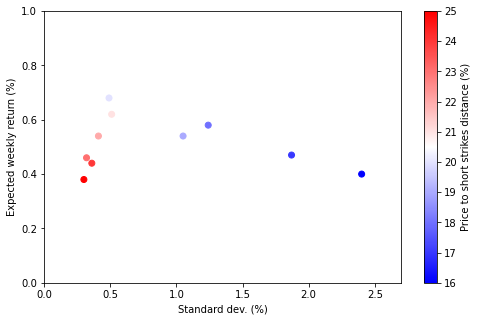

In [298]:
plt.figure(figsize=(8,5))
plt.scatter(sd_return, mean_return, c=limit, cmap='bwr')
plt.xlabel('Standard dev. (%)')
plt.ylabel('Expected weekly return (%)')
plt.colorbar(label='Price to short strikes distance (%)')
plt.clim([16, 25])
plt.xlim([0, 2.7])
plt.ylim([0, 1.]);

In the fiugre above, expected return and standard deviation of return is calculated for different short strike distances to closing price. The efficient frontier includes distance values larger than 20% (short put < 0.8$*$close and short call > 1.2$*$close). One can choose the proper value based on his/her own risk profile.